In [1]:
import gensim
from gensim import corpora, models, similarities, matutils
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from IPython.core.debugger import set_trace
from gensim.parsing.preprocessing import remove_stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle

### Load BTS lyrics dataset:

Original dataset from Kaggle is as shown below. To collect unique non-instrumental songs, data was manually organized. Valence scores for each song were added manually from an external dataset acquired using Spotify API. 

In [2]:
bts_data_raw = pd.read_csv('lyrics-v5.csv')
bts_data_raw

,id,album_title,eng_album_title,album_rd,album_seq,track_title,kor_track_title,eng_track_title,lyrics,hidden_track,remix,featured,performed_by,repackaged,lang,has_full_ver
0,0,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,1,Intro: 2 Cool 4 Skool (ft. DJ Friz),NaN,Intro: 2 Cool 4 Skool (ft. DJ Friz),we’re now going to progress to some steps\nwhi...,False,False,DJ Friz,RM,False,KOR,False
1,1,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,2,We Are Bulletproof Pt.2,NaN,We Are Bulletproof Pt.2,(what) give it to me\n (what) be nervous\n (wh...,False,False,NaN,BTS,False,KOR,False
2,2,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,3,Skit: Circle Room Talk,NaN,Skit: Circle Room Talk,rap monster: it was a big hit\nv: year 2006!\n...,False,False,NaN,BTS,False,KOR,False
3,3,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,4,No More Dream,NaN,No More Dream,"hey, what's your dream?\n hey, what’s your dre...",False,False,NaN,BTS,False,KOR,False
4,4,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,5,Interlude,NaN,Interlude,NaN,False,False,NaN,BTS,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,226,"Butter (Hotter, Sweeter, Cooler) - EP",NaN,2021-06-04,1,Butter,NaN,Butter,Smooth like butter\nLike a criminal undercover...,False,False,NaN,BTS,False,ENG,False
227,227,"Butter (Hotter, Sweeter, Cooler) - EP",NaN,2021-06-04,2,Butter (Hotter Remix),NaN,Butter (Hotter Remix),Smooth like butter\nLike a criminal undercover...,False,False,NaN,BTS,False,ENG,False
228,228,"Butter (Hotter, Sweeter, Cooler) - EP",NaN,2021-06-04,3,Butter (Sweeter Remix),NaN,Butter (Sweeter Remix),Smooth like butter\nLike a criminal undercover...,False,False,NaN,BTS,False,ENG,False
229,229,"Butter (Hotter, Sweeter, Cooler) - EP",NaN,2021-06-04,4,Butter (Cooler Remix),NaN,Butter (Cooler Remix),Smooth like butter\nLike a criminal undercover...,False,False,NaN,BTS,False,ENG,False


### Load manually organized unique song data:

In [3]:
bts_train_data = pd.read_csv('bts_train_data_yr.csv')
bts_test_data = pd.read_csv('bts_test_data_yr.csv')

In [4]:
bts_data_temp = pd.concat([bts_train_data, bts_test_data])
bts_data_temp

,track_title,valence,lyrics,album_yr
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013
...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020


### Preprocess data:

In [5]:
lowercase_lyrics = []

for lyrics in bts_data_temp['lyrics']:
    text = lyrics
    text = text.lower()
    lowercase_lyrics.append(text)

In [6]:
bts_data_temp['lowercase'] = lowercase_lyrics

In [7]:
bts_data_temp

,track_title,valence,lyrics,album_yr,lowercase
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013,we’re now going to progress to some steps\nwhi...
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013,(what) give it to me\n (what) be nervous\n (wh...
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013,"hey, what's your dream?\n hey, what’s your dre..."
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013,wanna be loved…\n\ndon’t wanna be fool wanna b...
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-..."
...,...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020,where is my angel?\nthe end of the day\nsomeon...
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020,every time during the same day\ni feel the hap...
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020,"mm, uh-oh\nuh, it looks like i lost something\..."
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020,was it a dream?\ni think i saw you\nwhen i ope...


In [8]:
from nltk.tokenize import word_tokenize

In [9]:
bts_data_temp['lyrics_tokenized'] = bts_data_temp['lowercase'].apply(word_tokenize)

In [10]:
bts_data_temp

,track_title,valence,lyrics,album_yr,lowercase,lyrics_tokenized
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013,we’re now going to progress to some steps\nwhi...,"[we, ’, re, now, going, to, progress, to, some..."
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013,(what) give it to me\n (what) be nervous\n (wh...,"[(, what, ), give, it, to, me, (, what, ), be,..."
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013,"hey, what's your dream?\n hey, what’s your dre...","[hey, ,, what, 's, your, dream, ?, hey, ,, wha..."
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013,wanna be loved…\n\ndon’t wanna be fool wanna b...,"[wan, na, be, loved…, don, ’, t, wan, na, be, ..."
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...","[hurry, up, ,, hurry-hurry-hurry-hurry-hurry-h..."
...,...,...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020,where is my angel?\nthe end of the day\nsomeon...,"[where, is, my, angel, ?, the, end, of, the, d..."
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020,every time during the same day\ni feel the hap...,"[every, time, during, the, same, day, i, feel,..."
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020,"mm, uh-oh\nuh, it looks like i lost something\...","[mm, ,, uh-oh, uh, ,, it, looks, like, i, lost..."
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020,was it a dream?\ni think i saw you\nwhen i ope...,"[was, it, a, dream, ?, i, think, i, saw, you, ..."


In [11]:
import string

In [12]:
def remove_punctuation_marks(tokens):
    clean_tokens = []
    for tok in tokens:
        if tok.isalpha():
            clean_tokens.append(tok)
    return clean_tokens

In [13]:
bts_data_temp['lyrics_clean_tokenized'] = bts_data_temp['lyrics_tokenized'].apply(remove_punctuation_marks)

In [14]:
bts_data_temp

,track_title,valence,lyrics,album_yr,lowercase,lyrics_tokenized,lyrics_clean_tokenized
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013,we’re now going to progress to some steps\nwhi...,"[we, ’, re, now, going, to, progress, to, some...","[we, re, now, going, to, progress, to, some, s..."
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013,(what) give it to me\n (what) be nervous\n (wh...,"[(, what, ), give, it, to, me, (, what, ), be,...","[what, give, it, to, me, what, be, nervous, wh..."
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013,"hey, what's your dream?\n hey, what’s your dre...","[hey, ,, what, 's, your, dream, ?, hey, ,, wha...","[hey, what, your, dream, hey, what, s, your, d..."
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013,wanna be loved…\n\ndon’t wanna be fool wanna b...,"[wan, na, be, loved…, don, ’, t, wan, na, be, ...","[wan, na, be, don, t, wan, na, be, fool, wan, ..."
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...","[hurry, up, ,, hurry-hurry-hurry-hurry-hurry-h...","[hurry, up, school, is, over, i, hungry, i, hu..."
...,...,...,...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020,where is my angel?\nthe end of the day\nsomeon...,"[where, is, my, angel, ?, the, end, of, the, d...","[where, is, my, angel, the, end, of, the, day,..."
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020,every time during the same day\ni feel the hap...,"[every, time, during, the, same, day, i, feel,...","[every, time, during, the, same, day, i, feel,..."
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020,"mm, uh-oh\nuh, it looks like i lost something\...","[mm, ,, uh-oh, uh, ,, it, looks, like, i, lost...","[mm, uh, it, looks, like, i, lost, something, ..."
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020,was it a dream?\ni think i saw you\nwhen i ope...,"[was, it, a, dream, ?, i, think, i, saw, you, ...","[was, it, a, dream, i, think, i, saw, you, whe..."


In [21]:
from nltk.stem import WordNetLemmatizer

In [22]:
lemmatizer = WordNetLemmatizer()
bts_data_temp['lyrics_lemmatized'] = bts_data_temp['lyrics_clean_tokenized'].apply(lambda x: [lemmatizer.lemmatize(lyric) for lyric in x])

In [23]:
bts_data_temp

,track_title,valence,lyrics,album_yr,lowercase,lyrics_tokenized,lyrics_clean_tokenized,lyrics_lemmatized
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013,we’re now going to progress to some steps\nwhi...,"[we, ’, re, now, going, to, progress, to, some...","[we, re, now, going, to, progress, to, some, s...","[we, re, now, going, to, progress, to, some, s..."
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013,(what) give it to me\n (what) be nervous\n (wh...,"[(, what, ), give, it, to, me, (, what, ), be,...","[what, give, it, to, me, what, be, nervous, wh...","[what, give, it, to, me, what, be, nervous, wh..."
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013,"hey, what's your dream?\n hey, what’s your dre...","[hey, ,, what, 's, your, dream, ?, hey, ,, wha...","[hey, what, your, dream, hey, what, s, your, d...","[hey, what, your, dream, hey, what, s, your, d..."
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013,wanna be loved…\n\ndon’t wanna be fool wanna b...,"[wan, na, be, loved…, don, ’, t, wan, na, be, ...","[wan, na, be, don, t, wan, na, be, fool, wan, ...","[wan, na, be, don, t, wan, na, be, fool, wan, ..."
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...","[hurry, up, ,, hurry-hurry-hurry-hurry-hurry-h...","[hurry, up, school, is, over, i, hungry, i, hu...","[hurry, up, school, is, over, i, hungry, i, hu..."
...,...,...,...,...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020,where is my angel?\nthe end of the day\nsomeon...,"[where, is, my, angel, ?, the, end, of, the, d...","[where, is, my, angel, the, end, of, the, day,...","[where, is, my, angel, the, end, of, the, day,..."
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020,every time during the same day\ni feel the hap...,"[every, time, during, the, same, day, i, feel,...","[every, time, during, the, same, day, i, feel,...","[every, time, during, the, same, day, i, feel,..."
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020,"mm, uh-oh\nuh, it looks like i lost something\...","[mm, ,, uh-oh, uh, ,, it, looks, like, i, lost...","[mm, uh, it, looks, like, i, lost, something, ...","[mm, uh, it, look, like, i, lost, something, i..."
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020,was it a dream?\ni think i saw you\nwhen i ope...,"[was, it, a, dream, ?, i, think, i, saw, you, ...","[was, it, a, dream, i, think, i, saw, you, whe...","[wa, it, a, dream, i, think, i, saw, you, when..."


In [25]:
#POS tagging:

tagged_tokens=[]
for token in bts_data_temp['lyrics_lemmatized'].to_list():
    tagged_tokens.append(nltk.pos_tag(token))

In [26]:
#collect nouns, verbs and adjectives

tag_list = []
for song in tagged_tokens:
    tag_list.append([(word,tag) for word, tag in song if tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ')])

In [27]:
word_list = []
for song in tag_list:
    word_list.append([word for word, tag in song])

In [28]:
bts_data_temp['lyrics_processed'] = [' '.join(song) for song in word_list]

In [29]:
bts_data_temp

,track_title,valence,lyrics,album_yr,lowercase,lyrics_tokenized,lyrics_clean_tokenized,lyrics_lemmatized,lyrics_processed
0,Intro: 2 Cool 4 Skool (ft. DJ Friz),0.553,we’re now going to progress to some steps\nwhi...,2013,we’re now going to progress to some steps\nwhi...,"[we, ’, re, now, going, to, progress, to, some...","[we, re, now, going, to, progress, to, some, s...","[we, re, now, going, to, progress, to, some, s...",re going progress step are difficult ready set...
1,We Are Bulletproof Pt.2,0.868,(what) give it to me\n (what) be nervous\n (wh...,2013,(what) give it to me\n (what) be nervous\n (wh...,"[(, what, ), give, it, to, me, (, what, ), be,...","[what, give, it, to, me, what, be, nervous, wh...","[what, give, it, to, me, what, be, nervous, wh...",give be nervous one end are are bulletproof na...
2,No More Dream,0.612,"hey, what's your dream?\n hey, what’s your dre...",2013,"hey, what's your dream?\n hey, what’s your dre...","[hey, ,, what, 's, your, dream, ?, hey, ,, wha...","[hey, what, your, dream, hey, what, s, your, d...","[hey, what, your, dream, hey, what, s, your, d...",hey dream hey s dream hey dream hey is dream i...
3,좋아요 (I Like It),0.768,wanna be loved…\n\ndon’t wanna be fool wanna b...,2013,wanna be loved…\n\ndon’t wanna be fool wanna b...,"[wan, na, be, loved…, don, ’, t, wan, na, be, ...","[wan, na, be, don, t, wan, na, be, fool, wan, ...","[wan, na, be, don, t, wan, na, be, fool, wan, ...",wan be don t wan be fool be cool be loved same...
4,Outro: Circle Room Cypher,0.866,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",2013,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...","[hurry, up, ,, hurry-hurry-hurry-hurry-hurry-h...","[hurry, up, school, is, over, i, hungry, i, hu...","[hurry, up, school, is, over, i, hungry, i, hu...",hurry school is i hungry i hungry i wan eat na...
...,...,...,...,...,...,...,...,...,...
15,Blue & Grey,0.364,Where is my angel?\nThe end of the day\nSomeon...,2020,where is my angel?\nthe end of the day\nsomeon...,"[where, is, my, angel, ?, the, end, of, the, d...","[where, is, my, angel, the, end, of, the, day,...","[where, is, my, angel, the, end, of, the, day,...",is end day someone come save please weary sigh...
16,Telepathy,0.570,Every time during the same day\nI feel the hap...,2020,every time during the same day\ni feel the hap...,"[every, time, during, the, same, day, i, feel,...","[every, time, during, the, same, day, i, feel,...","[every, time, during, the, same, day, i, feel,...",time same day i feel happiest i meet time diff...
17,Dis-ease,0.484,"Mm, uh-oh\nUh, it looks like I lost something\...",2020,"mm, uh-oh\nuh, it looks like i lost something\...","[mm, ,, uh-oh, uh, ,, it, looks, like, i, lost...","[mm, uh, it, looks, like, i, lost, something, ...","[mm, uh, it, look, like, i, lost, something, i...",mm uh look i lost something i relieve anxiety ...
18,Stay,0.341,Was it a dream?\nI think I saw you\nWhen I ope...,2020,was it a dream?\ni think i saw you\nwhen i ope...,"[was, it, a, dream, ?, i, think, i, saw, you, ...","[was, it, a, dream, i, think, i, saw, you, whe...","[wa, it, a, dream, i, think, i, saw, you, when...",wa dream i think i saw i open eye room empty h...


In [30]:
from nltk.corpus import stopwords

#nltk.download('stopwords')
stop = set(stopwords.words('english'))

In [32]:
import re

def process(text):
    text = text.lower()
    # only preserve words that have three or more characters
    text_filt = re.findall(r'\b[a-zA-Z]{3,}\b' , text)
    
    #remove words that are commonly used in pop music lyrics that don't have particularly significant meanings
    bts_words = {'gon', 'hey', 'ayy', 'yeah', 'wan', 'girl', 'baby', 'ugh','owoah', 'whoa', 'woo', 'ooh'}
    
    words_filtp = [w for w in text_filt if w not in stop]
    words_filt = [w for w in words_filtp if w not in bts_words]
    return words_filt

In [33]:
bts_data_temp['dictionary'] = bts_data_temp['lyrics_processed'].apply(process)

In [34]:
bts_data_temp['dictionary']

0     [going, progress, step, difficult, ready, set,...
1     [give, nervous, one, end, bulletproof, name, j...
2     [dream, dream, dream, dream, big, house, big, ...
3     [fool, cool, loved, love, want, picture, post,...
4     [hurry, school, hungry, hungry, eat, nanakon, ...
                            ...                        
15    [end, day, someone, come, save, please, weary,...
16    [time, day, feel, happiest, meet, time, differ...
17    [look, lost, something, relieve, anxiety, sip,...
18    [dream, think, saw, open, eye, room, empty, ho...
19    [thought, young, heart, drum, beating, louder,...
Name: dictionary, Length: 131, dtype: object

---

## Traning LDA model

In [35]:
dictionary = corpora.Dictionary(bts_data_temp.dictionary)

dictionary.save('dictionary.dict')

In [36]:
# create document and term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in bts_data_temp.dictionary]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [37]:
seed = 123
Lda = models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary,\
               alpha='auto', eta='auto', iterations = 400,\
               passes=20, eval_every = 1, random_state = seed)

In [38]:
ldamodel.print_topics()

[(0,
  '0.022*"know" + 0.018*"let" + 0.013*"day" + 0.012*"bang" + 0.010*"fine" + 0.009*"want" + 0.008*"say" + 0.007*"way" + 0.007*"fun" + 0.007*"moment"'),
 (1,
  '0.015*"know" + 0.009*"converse" + 0.009*"want" + 0.009*"save" + 0.008*"high" + 0.008*"get" + 0.008*"stay" + 0.007*"yolo" + 0.007*"time" + 0.007*"squandering"'),
 (2,
  '0.022*"dream" + 0.017*"say" + 0.014*"make" + 0.012*"want" + 0.012*"world" + 0.012*"love" + 0.012*"know" + 0.010*"life" + 0.009*"got" + 0.009*"crazy"'),
 (3,
  '0.056*"love" + 0.020*"know" + 0.016*"drink" + 0.016*"fall" + 0.014*"respect" + 0.009*"say" + 0.008*"live" + 0.008*"look" + 0.008*"fake" + 0.007*"shot"'),
 (4,
  '0.026*"let" + 0.014*"jump" + 0.012*"get" + 0.010*"time" + 0.009*"feel" + 0.009*"hand" + 0.008*"want" + 0.008*"look" + 0.008*"say" + 0.008*"day"'),
 (5,
  '0.021*"city" + 0.021*"today" + 0.017*"fly" + 0.014*"hand" + 0.011*"wing" + 0.010*"night" + 0.010*"want" + 0.010*"trust" + 0.010*"come" + 0.009*"shine"'),
 (6,
  '0.029*"love" + 0.017*"let" +

In [39]:
d = corpora.Dictionary.load('dictionary.dict')
c = corpora.MmCorpus('corpus.mm')

In [41]:
#measure topic coherence

from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model = ldamodel, texts=bts_data_temp.dictionary, dictionary = d, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score c_v: ', coherence_lda)


Coherence Score c_v:  0.31609061528945837


In [42]:
coherence_model_lda = CoherenceModel(model = ldamodel, texts=bts_data_temp.dictionary, dictionary = d, coherence = 'u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score UMass: ', coherence_lda)


Coherence Score UMass:  -3.4814604180975928


In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=Lda(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
# seed = 123
# Lda = models.ldamodel.LdaModel
# ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary,\
#                alpha='auto', eta='auto', iterations = 400,\
#                passes=20, eval_every = 1, random_state = seed)

def compute_coherence_values2(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        seed = 123
        model=Lda(corpus=corpus, id2word=dictionary, num_topics=num_topics,\
               alpha='auto', eta='auto', iterations = 400,\
               passes=20, eval_every = 1, random_state = seed)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### To find optimal number of topics: graph coherence vs. number of topics 

(Note: this runs differently each time)

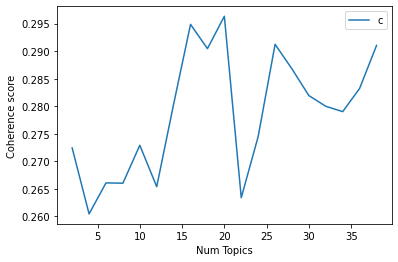

In [48]:
model_list, coherence_values = compute_coherence_values(dictionary=d, corpus=c, texts=bts_data_temp.dictionary, start=2, limit=40, step=2)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Use pyLDAvis for PCA to 2D visualization of topics

In [49]:
vis_data = gensimvis.prepare(ldamodel, c, d)
pyLDAvis.display(vis_data)

/Users/fatimaloissuarez/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fatimaloissuarez/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fatimaloissuarez/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fatimaloissuarez/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/fatimaloissuarez/opt/anac

---

## Assigning topics to each song

In [50]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
#tfidf_vect = TfidfVectorizer(ngram_range=(1,1),stop_words='english',token_pattern='\\b[a-z][a-z][a-z]+\\b')

In [52]:
#tfidf_vect.fit(bts_data_temp.lyrics_processed)
count_vectorizer = CountVectorizer(ngram_range=(1,1),stop_words='english',token_pattern='\\b[a-z][a-z][a-z]+\\b')
count_vectorizer.fit(bts_data_temp.lyrics_processed)

CountVectorizer(stop_words='english', token_pattern='\\b[a-z][a-z][a-z]+\\b')

In [53]:
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(bts_data_temp.lyrics_processed).transpose()

In [54]:
# convert sparse matrix to genism corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [55]:
# tranform doc from word space to the topic space (like transform in sklearn)
lda_corpus = ldamodel[corpus]

In [59]:
#show topic distribution for each song 
lda_docs = [doc for doc in lda_corpus]

In [60]:
lda_docs

[[(0, 0.2756614),
  (1, 0.36607015),
  (2, 0.115915574),
  (5, 0.06554443),
  (6, 0.1751932)],
 [(0, 0.25650114),
  (1, 0.11223836),
  (2, 0.17664151),
  (3, 0.27335653),
  (4, 0.13247123),
  (6, 0.042053506)],
 [(0, 0.10341149),
  (1, 0.32034618),
  (2, 0.021806851),
  (3, 0.04518379),
  (4, 0.06964982),
  (5, 0.062114984),
  (6, 0.37748688)],
 [(0, 0.31935233),
  (1, 0.26127514),
  (2, 0.06925189),
  (3, 0.07646397),
  (4, 0.14054608),
  (5, 0.025531158),
  (6, 0.10757947)],
 [(0, 0.25007653),
  (1, 0.2335792),
  (2, 0.15093106),
  (3, 0.06973351),
  (4, 0.104172334),
  (5, 0.06981702),
  (6, 0.12169037)],
 [(0, 0.112476535),
  (1, 0.2620645),
  (2, 0.10479249),
  (3, 0.049330804),
  (4, 0.060916025),
  (5, 0.23721205),
  (6, 0.17320763)],
 [(0, 0.17358142),
  (1, 0.40770796),
  (2, 0.1706135),
  (3, 0.110354125),
  (5, 0.060476642),
  (6, 0.077043556)],
 [(0, 0.31679177),
  (1, 0.3074556),
  (2, 0.096445166),
  (3, 0.09640233),
  (4, 0.05068962),
  (5, 0.040171213),
  (6, 0.09204431

In [61]:
topic_lst = []
for lst in lda_docs:
    if len(lst) == 1:
        topic_lst.append(lst[0][0])
    else:
        topic_lst.append(max(lst, key=lambda x:x[1])[0])

In [62]:
topic_lst

[1,
 3,
 6,
 0,
 0,
 1,
 1,
 0,
 0,
 6,
 0,
 1,
 1,
 6,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 4,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 4,
 1,
 4,
 1,
 2,
 0,
 0,
 4,
 4,
 1,
 3,
 3,
 3,
 4,
 4,
 1,
 0,
 1,
 1,
 4,
 6,
 0,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 0,
 4,
 3,
 1,
 1,
 6,
 1,
 1,
 1,
 4,
 0,
 1,
 1,
 3,
 3,
 0,
 1,
 1,
 1,
 0,
 6,
 4,
 0,
 1,
 0,
 0,
 1,
 1,
 4,
 6,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 6,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 4,
 1,
 0,
 2,
 0,
 0,
 4,
 1,
 1,
 1,
 0,
 1]

In [63]:
ldamodel.print_topics()

[(0,
  '0.022*"know" + 0.018*"let" + 0.013*"day" + 0.012*"bang" + 0.010*"fine" + 0.009*"want" + 0.008*"say" + 0.007*"way" + 0.007*"fun" + 0.007*"moment"'),
 (1,
  '0.015*"know" + 0.009*"converse" + 0.009*"want" + 0.009*"save" + 0.008*"high" + 0.008*"get" + 0.008*"stay" + 0.007*"yolo" + 0.007*"time" + 0.007*"squandering"'),
 (2,
  '0.022*"dream" + 0.017*"say" + 0.014*"make" + 0.012*"want" + 0.012*"world" + 0.012*"love" + 0.012*"know" + 0.010*"life" + 0.009*"got" + 0.009*"crazy"'),
 (3,
  '0.056*"love" + 0.020*"know" + 0.016*"drink" + 0.016*"fall" + 0.014*"respect" + 0.009*"say" + 0.008*"live" + 0.008*"look" + 0.008*"fake" + 0.007*"shot"'),
 (4,
  '0.026*"let" + 0.014*"jump" + 0.012*"get" + 0.010*"time" + 0.009*"feel" + 0.009*"hand" + 0.008*"want" + 0.008*"look" + 0.008*"say" + 0.008*"day"'),
 (5,
  '0.021*"city" + 0.021*"today" + 0.017*"fly" + 0.014*"hand" + 0.011*"wing" + 0.010*"night" + 0.010*"want" + 0.010*"trust" + 0.010*"come" + 0.009*"shine"'),
 (6,
  '0.029*"love" + 0.017*"let" +

In [65]:
# 0: know let day bang fine want stay way fun moment
# 1: know converse want save high get stay yolo time squandering
# 2: dream say make want world love know life got crazy
# 3: love know drink fall respect say live look fake shot
# 4: let jump get time feel hand want look say day
# 5: city today fly hand wing night want trust come shine
# 6: love let run need say keep day stop sunday turn

topic_map = {'0': 'topic 1',\
            '1': 'topic 2',\
            '2': 'topic 3',\
            '3': 'topic 4',\
            '4': 'topic 5',\
            '5': 'topic 6',\
            '6': 'topic 7'}

In [66]:
# map topic name with track_title
bts_data_temp['topic'] = topic_lst
bts_data_temp['topic'] = bts_data_temp['topic'].astype(str)
bts_data_temp["topic"].replace(topic_map, inplace=True)

In [69]:
#display number of songs per topic
bts_topics = bts_data_temp.groupby(['topic']).count()

In [70]:
bts_topics

,track_title,valence,lyrics,album_yr,lowercase,lyrics_tokenized,lyrics_clean_tokenized,lyrics_lemmatized,lyrics_processed,dictionary
topic,,,,,,,,,,
topic 1,40,40,40,40,40,40,40,40,40,40
topic 2,59,59,59,59,59,59,59,59,59,59
topic 3,2,2,2,2,2,2,2,2,2,2
topic 4,7,7,7,7,7,7,7,7,7,7
topic 5,15,15,15,15,15,15,15,15,15,15
topic 7,8,8,8,8,8,8,8,8,8,8


In [72]:
# count the number of songs in each topic and album
topic_album = bts_data_temp.groupby(['album_yr','topic'])['lyrics'].count().reset_index()

In [73]:
topic_album = topic_album.rename(columns = {'lyric':'song_count'})

In [74]:
topic_album

,album_yr,topic,lyrics
0,2013,topic 1,6
1,2013,topic 2,5
2,2013,topic 4,1
3,2013,topic 7,3
4,2014,topic 1,6
5,2014,topic 2,13
6,2014,topic 3,1
7,2014,topic 5,2
8,2015,topic 1,6
9,2015,topic 2,5


In [75]:
year_topic = topic_album.sort_values(by=['album_yr'])

Text(0.5, 1.0, 'Song Topics over the Years')

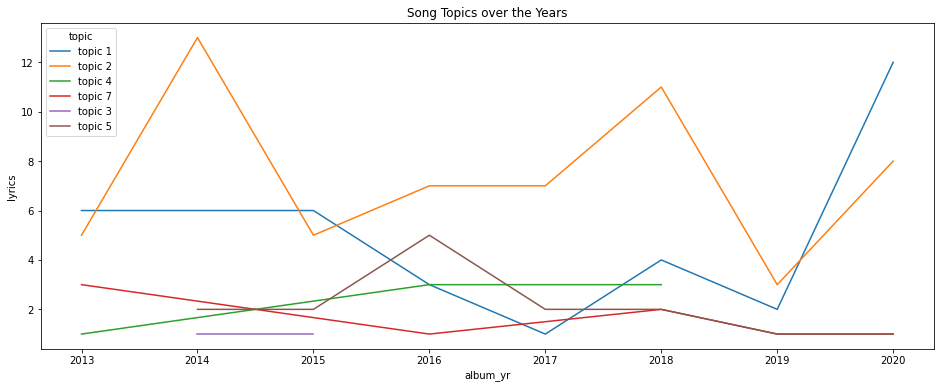

In [76]:
# plot song topics over the years graph
plt.figure(figsize=(16, 6))
sns.lineplot(x="album_yr", y="lyrics", hue="topic",data=year_topic)
plt.title('Song Topics over the Years')